# Grover's Algorithm on Quantum RAM

This notebook is part of my application to QOSF's mentorship program (cohort 4). This is task 1.

The goal here was to implement a quantum RAM, and perform Grover's algorthm to search over the RAM for a string satisfying the particular condition that it does not have 2 consecutive ones or zeroes. 

This solution leaves the address register in a superposition of the indices of the desired strings.

In [1]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import ZGate
from qiskit.quantum_info import Operator, Statevector
from qiskit.extensions import Initialize
from qiskit.providers.aer import AerSimulator
from qiskit.providers.aer.backends import statevector_simulator, qasm_simulator
from qiskit.visualization import plot_histogram, plot_state_city
from qiskit import Aer, execute, transpile
import numpy as np

First, we need to identify the desired strings, or "winners" of the search.

Given a fixed length of the bitstring, it is trivial to see that there only 2 possible winners - alternating strings of $0$ and $1$, one beginning with $0$, and the other with $1$. In other words, the strings we are looking for are $010...$ and $101...$.

In [2]:
def targets(n):
    state1 = ""
    state2 = ""
    bits = ["0", "1"]
    for i in range(n):
        state1 += bits[i%2]
        state2 += bits[1-(i%2)]
    return state1, state2

To load the data entered by the user into the qRAM, we need construct a string which is a concatenation of the binary representation of the elements of the input array. We will use this string to set the memory qubit values in the qRAM circuit.

In [3]:
def getData(input_array, mem_bits):
    state = ""
    for i in input_array:
        state += bin(i)[2:].rjust(mem_bits, '0')
    return state[::-1]

An integral part of the structure of the qRAM is the auxillary register $\tau$. This register simply stores the selected address $a$ by setting the $a^{th}$ qubit value as $|1⟩$, and all the others as $|0⟩$. To do this, the address register and auxillary register are entangled. This operation is commonly performed by a [decoder](https://www.javatpoint.com/decoder-digital-electronics).

In [4]:
def decoder(addr_bits, aux_bits, n):
    addr = QuantumRegister(addr_bits)
    tau = QuantumRegister(aux_bits)
    
    decoder = QuantumCircuit(addr, tau)
    
    decoder.x(tau[0])
    decoder.cx(addr[addr_bits-1], tau[1])
    decoder.cx(tau[1], tau[0])
    
    c = 1
    
    for i in range(1, addr_bits-1):
        p = 2**i
        for j in range(p):
            decoder.ccx(addr[addr_bits-i-1], tau[j], tau[p+j])
            c += 1
        for j in range(p):
            decoder.cx(tau[p+j], tau[j])
    p = aux_bits - 1 - c 
    for j in range(p):
        decoder.ccx(addr[0], tau[j], tau[p+j])
        c += 1
    for j in range(p):
        decoder.cx(tau[p+j], tau[j])
    
    
    return decoder.to_gate(label = "Decoder")

This brings us to the main event - Grover's Algorithm.

Grover's Algorithm consists of 2 main steps - 
1. Introducing a negative phase on the winners (or a reflection about the initial state)
2. Boosting the amplitude of the states with a negative phase (or a rotation towards the winning state)

To introduce a negative phase on the winning states, we first introduce a negative phase on the respective qubits in register $\tau$. We do this by applying two controlled-Z operation on each qubit in $\tau$, keeping the two winning strings as the control states, and the respective qubits in the memory register as the control qubits.

In [5]:
def groverOracle(aux_bits, mem_bits, n):
    winners = targets(mem_bits)
    
    tau = QuantumRegister(aux_bits)
    mem = QuantumRegister(mem_bits*n)
    oracle = QuantumCircuit(tau, mem)
    
    gate1 = ZGate().control(num_ctrl_qubits=mem_bits, ctrl_state=winners[0])
    gate2 = ZGate().control(num_ctrl_qubits=mem_bits, ctrl_state=winners[1])

    for i in range(aux_bits):
        qubits = [mem[mem_bits*i + j] for j in range(mem_bits)]
        oracle.append(gate1, qubits + [tau[i]])
        oracle.append(gate2, qubits + [tau[i]])
    
    return oracle.to_gate(label="Oracle")

The amplification is done by the standard diffuser operator, given by 
<p style="text-align:center">
$U_s = 2|s\rangle\langle s| - 1$
</p>
Where $|s\rangle$ is the equal superposition state, and $1$ is the identity operator.

In [6]:
def groverDiffuser(addr_bits):
    d = 2**addr_bits
    s = np.array([[1.0/np.sqrt(d)] for i in range(d)])
    op = np.matmul(s, s.T)
    U_S = Operator((2*op)-np.identity(d))
    return U_S

We now bring everything together. 

In [7]:
def qram(input_array):
        
    n = len(input_array)
    if n < 8:
        input_array += [0 for i in range(8-n)]
    n = len(input_array)  
    
    addr_bits = len(bin(n-1)) - 2                       # number of address bits
    aux_bits = n                                        # number of memory locations
    mem_bits = len(bin(max(input_array))) - 2           # size of one memory location
    
    
    addr = QuantumRegister(addr_bits, name="a")         # address register
    tau = QuantumRegister(aux_bits, name="tau")         # auxillary register to store selected address
    mem = QuantumRegister(mem_bits*n, name="m")         # memory register
    cr = ClassicalRegister(addr_bits)                   # to store final output
    
    qram_circ = QuantumCircuit(addr, tau, mem, cr)
    
    for i in range(addr_bits):
        qram_circ.h(addr[i])
    
    # Load data into qRAM
    data = getData(input_array[::-1], mem_bits)
    for i in range(len(data)):
        if data[i] == "1":
            qram_circ.x(mem[i])
    # End of loading
    
        
    # Entangle tau with addr
    decode = decoder(addr_bits, aux_bits, n)
    qram_circ.append(decode, addr[:] + tau[:])

    # Grover oracle
    oracle = groverOracle(aux_bits, mem_bits, n)
    qram_circ.append(oracle, tau[:] + mem[:])
    # End of grover oracle

    # Detangle tau from addr
    encode = decode.inverse()
    encode.label = "Encoder"
    qram_circ.append(encode, addr[:] + tau[:])

    # Diffuser
    U_S = groverDiffuser(addr_bits)
    qram_circ.append(U_S, [addr[i] for i in range(addr_bits)])
    
    # Measure    
    qram_circ.measure([addr[i] for i in range(addr_bits)], [cr[i] for i in range(addr_bits)])
    
    return qram_circ

A few points to note - 
1. Grover's algorithm does not work if the number of winners $\ge$ $0.5 * $ number of possible values. Since it has been guaranteed that two winners will always be provided in the input, we ensure that the number of memory locations is always $\ge 8$, by padding the input array with zeroes if necessary.

2. The final measurement outcome is displayed in big-endian notation.

3. The input $[1, 5, 7, 10]$ is not simulable as the number of qubits is too many for the simulator. Example 1 illustrates a similar example which uses lesser number of qubits per memory location.

## Example 1

```input_array``` = $[3, \textbf{2}, 1, \textbf{0}]$

Indices : $(1, 3) = (001, 011)$

Expected output = $\frac{|100\rangle + |110\rangle}{\sqrt{2}}$

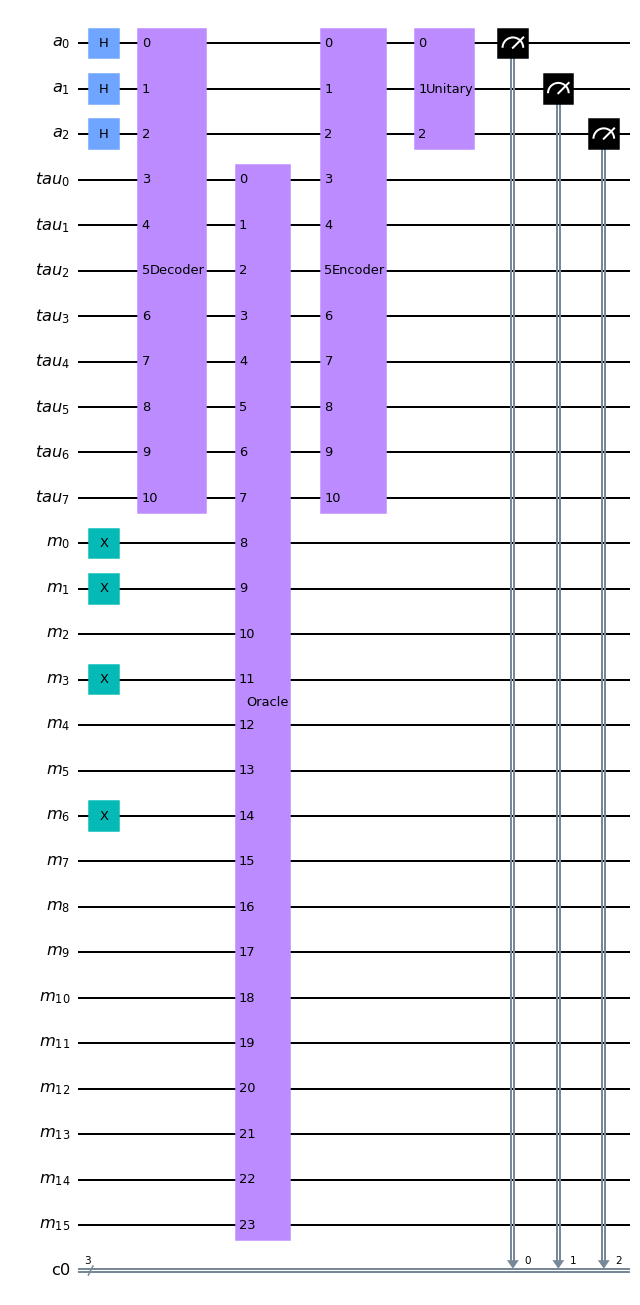

In [8]:
circ = qram([3, 2, 0, 1])
circ.draw('mpl')

{'100': 539, '110': 485}


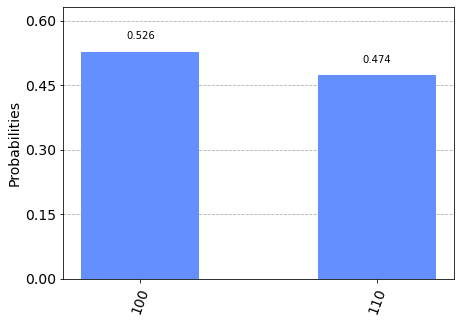

In [9]:
backend = Aer.get_backend("qasm_simulator")
job = execute(circ, backend)
res = job.result()
counts = res.get_counts()
print(counts)
plot_histogram(counts)

## Example 2

```input_array``` = $[\textbf{1}, 0, 3, \textbf{2}, 3]$

Indices : $(0, 3) = (000, 011)$

Expected output = $\frac{|000\rangle + |110\rangle}{\sqrt{2}}$

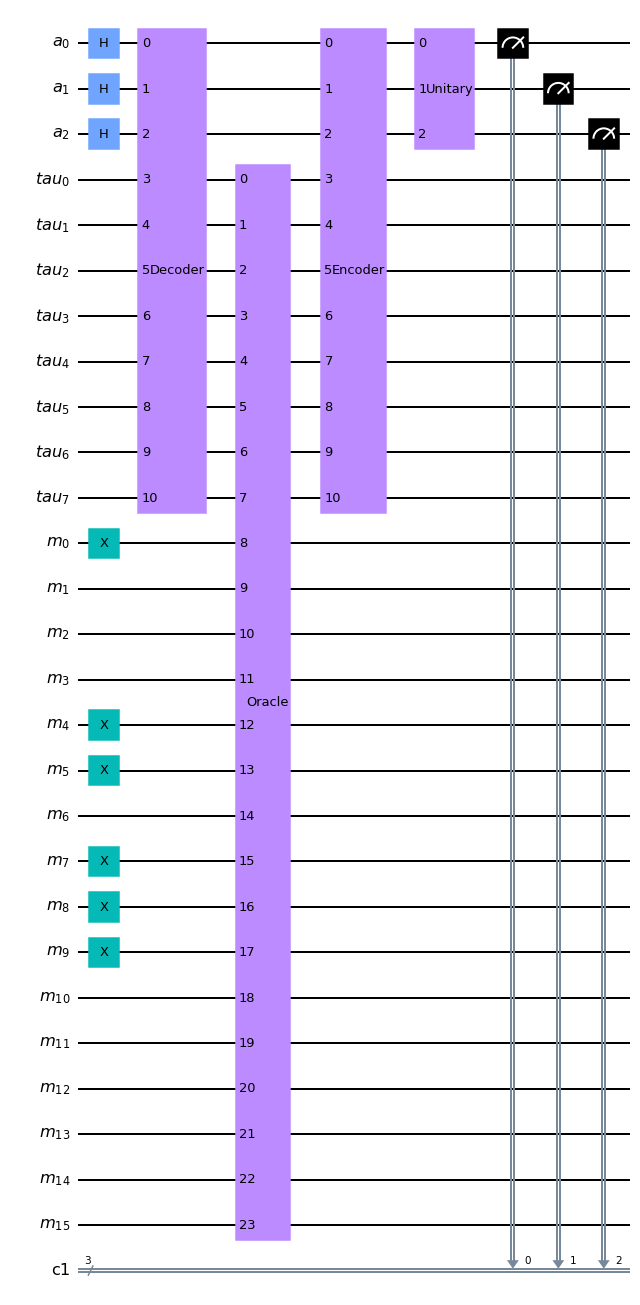

In [10]:
circ = qram([1, 0, 3, 2, 3])
circ.draw('mpl')

{'000': 496, '110': 528}


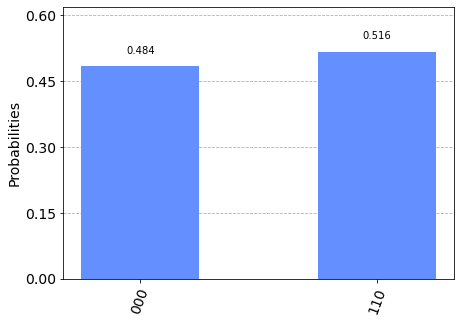

In [11]:
backend = Aer.get_backend("qasm_simulator")
job = execute(circ, backend)
res = job.result()
counts = res.get_counts()
print(counts)
plot_histogram(counts)

## Example 3

This is an instance in which the winner has been repeated.

```input_array``` = $[0, \textbf{1}, 3, \textbf{2}, \textbf{2}]$

Indices : $(1, 3, 4) = (001, 011, 100)$

Expected output = $\frac{|001\rangle + |100\rangle + |110\rangle}{\sqrt{3}}$

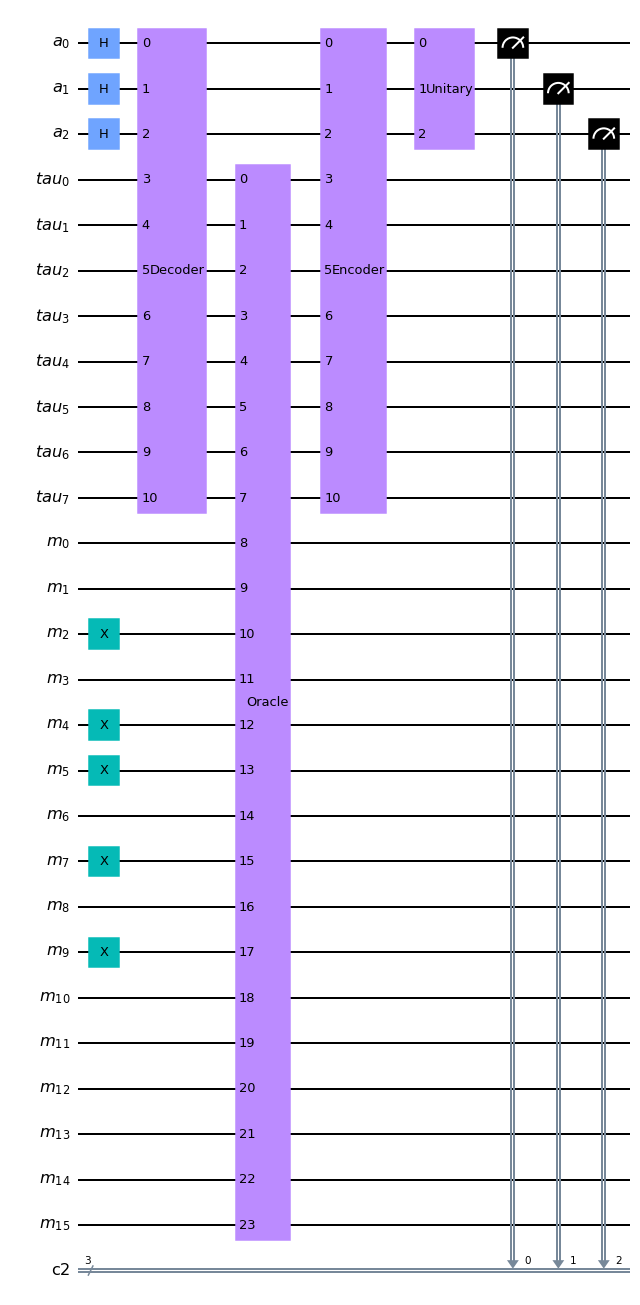

In [12]:
circ = qram([0, 1, 3, 2, 2])
circ.draw('mpl')

{'100': 294, '110': 284, '001': 290, '011': 31, '101': 32, '111': 29, '010': 30, '000': 34}


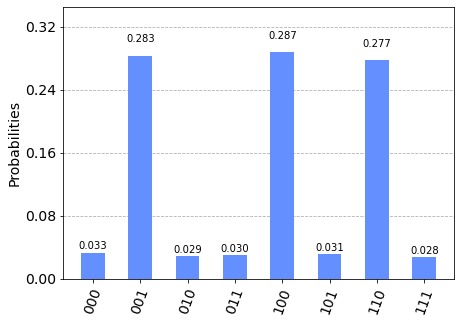

In [13]:
backend = Aer.get_backend("qasm_simulator")
job = execute(circ, backend)
res = job.result()
counts = res.get_counts()
print(counts)
plot_histogram(counts)